## Application of BPR on Movielens

In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
from subprocess import call
from pybpr import *
import matplotlib.pyplot as plt
from functools import partial

Number of users: 8
Number of items: 10
Number of users: 4
Number of items: 5


In [273]:
%%time
#df = load_movielens_data('ml-1m')
df = load_movielens_data('ml-100k')
df.head()

CPU times: user 2.08 ms, sys: 16.7 ms, total: 18.8 ms
Wall time: 21 ms


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [274]:
df['user_id'] = df['user_id'].astype('category')
df['item_id'] = df['item_id'].astype('category')
df['user_idx'] = df['user_id'].cat.codes
df['item_idx'] = df['item_id'].cat.codes
df.head()

,user_id,item_id,rating,timestamp,user_idx,item_idx
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [277]:
df.user_idx.nunique(), df.item_idx.nunique()

(943, 1682)

In [303]:
dfp = df[df['rating'] > 3].copy()
dfn = df[df['rating'] <= 3].copy()

In [304]:
pos_count = dfp.groupby('user_idx')['item_idx'].count().sort_values(ascending=False)
pos_count = pos_count[pos_count > 5]
neg_count = dfn.groupby('user_idx')['item_idx'].count().sort_values(ascending=False)
neg_count = neg_count[neg_count > 5]

In [305]:
uvec = np.intersect1d(neg_count.index.values, pos_count.index.values, assume_unique=True)
dfp = dfp[dfp.user_idx.isin(uvec)]
dfn = dfn[dfn.user_idx.isin(uvec)]

In [306]:
dfp.user_idx.nunique(), dfn.user_idx.nunique()

(885, 885)

In [307]:
uvec = np.intersect1d(dfp.user_idx.unique(), dfn.user_idx.unique(), assume_unique=True)
dfp = dfp[dfp.user_idx.isin(uvec)]
dfn = dfn[dfn.user_idx.isin(uvec)]
ivec = np.intersect1d(dfp.item_idx.unique(), dfn.item_idx.unique(), assume_unique=True)
dfp = dfp[dfp.item_idx.isin(ivec)]
dfn = dfn[dfn.item_idx.isin(ivec)]

In [308]:
dfp['user_idxx'] = 0
dfn['user_idxx'] = 0
for i, idx in enumerate(dfp.user_idx.unique()):
    dfp.loc[dfp.user_idx==idx,'user_idxx'] = i
    dfn.loc[dfn.user_idx==idx,'user_idxx'] = i
dfp['item_idxx'] = 0
dfn['item_idxx'] = 0
for i, idx in enumerate(dfp.item_idx.unique()):
    dfp.loc[dfp.item_idx==idx,'item_idxx'] = i
    dfn.loc[dfn.item_idx==idx,'item_idxx'] = i

In [309]:
dfp.user_idxx.nunique(), dfp.user_idxx.max()
dfn.user_idxx.nunique(), dfn.user_idxx.max()

(885, 884)

In [310]:
cfp = UserItemInteractions(
    name='MovieLens-100k',
    users=dfp['user_idxx'],
    items=dfp['item_idxx'],
    min_num_rating_per_user=0,
    min_num_rating_per_item=0,
    num_cores = 1
)
cfp.generate_train_test(user_test_ratio=0.2)
cfn = UserItemInteractions(
    name='MovieLens-100k',
    users=dfn['user_idxx'],
    items=dfn['item_idxx'],
    min_num_rating_per_user=0,
    min_num_rating_per_item=0,
    num_cores = 1
)
cfn.generate_train_test(user_test_ratio=0.2)

Number of users: 885
Number of items: 1400
Number of users: 885
Number of items: 1400


In [311]:
cfp.R_train, cfp.R_test, dfp.shape
cfn.R_train, cfn.R_test, dfp.shape

(<885x1400 sparse matrix of type '<class 'numpy.int8'>'
 	with 34485 stored elements in Compressed Sparse Row format>,
 <885x1400 sparse matrix of type '<class 'numpy.int8'>'
 	with 9068 stored elements in Compressed Sparse Row format>,
 (53984, 8))

In [312]:
cfn.R, dfn.shape

(<885x1400 sparse matrix of type '<class 'numpy.int8'>'
 	with 43553 stored elements in Compressed Sparse Row format>,
 (43553, 8))

In [313]:
np.allclose(np.sort(dfp.user_id.unique()), np.sort(dfn.user_id.unique()))
#np.allclose(np.sort(dfp.item_id.unique()), np.sort(dfn.item_id.unique()))

True

In [326]:
bpr = BPR(
    num_features=40,
    reg_lambda=0.00,
    num_iters=500,
    learning_rate = 0.04,
    batch_size=10,
    initial_std=0.001,
    seed=None
)

In [327]:
#bpr.fit(train_mat=cfp.R, train_mat_neg=cfn.R, ndcg_func=ndcg_fun_p)
ndcg_fun_p = partial(
    cfp.get_ndcg_metric,
    num_items=5
)
bpr.fit(
    train_mat=cfp.R_train, 
    train_mat_neg=cfn.R, 
    ndcg_func=ndcg_fun_p)
ndcg_df = pd.DataFrame(bpr.ndcg_metric)

BPR: 100%|██████████████████████████████████████████████| 500/500 [00:28<00:00, 17.78it/s]


In [328]:
bpr.fit(train_mat=cfp.R_train, ndcg_func=ndcg_fun_p)
ndcg_df2 = pd.DataFrame(bpr.ndcg_metric)

BPR: 100%|██████████████████████████████████████████████| 500/500 [00:31<00:00, 15.73it/s]


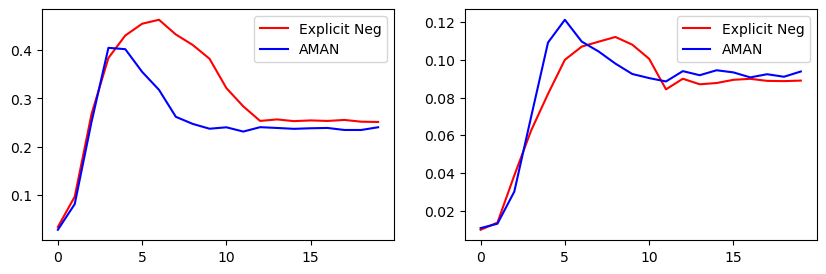

In [329]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(ndcg_df['train'],'-r', label='Explicit Neg')
ax[0].plot(ndcg_df2['train'],'-b', label='AMAN')
ax[1].plot(ndcg_df['test'],'-r', label='Explicit Neg')
ax[1].plot(ndcg_df2['test'],'-b', label='AMAN')
for iax in ax:
    iax.legend()

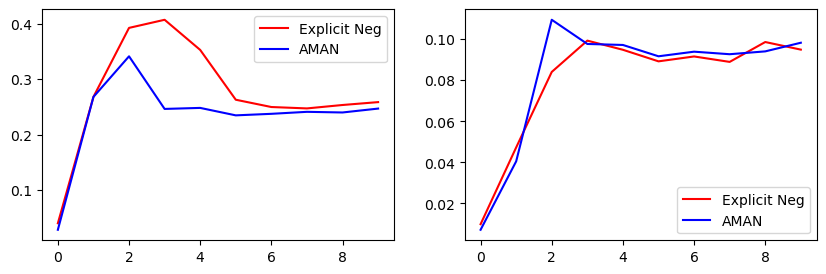

In [317]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(ndcg_df['train'],'-r', label='Explicit Neg')
ax[0].plot(ndcg_df2['train'],'-b', label='AMAN')
ax[1].plot(ndcg_df['test'],'-r', label='Explicit Neg')
ax[1].plot(ndcg_df2['test'],'-b', label='AMAN')
for iax in ax:
    iax.legend()

In [ ]:
bpr.fit(train_mat=cfp.R, ndcg_func=ndcg_fun_p)

In [ ]:
rec1 = cfp.get_top_items_for_this_user(10, bpr.user_mat, bpr.item_mat,5)
rec2 = cfp.get_top_items_for_this_user(10, bpr2.user_mat, bpr.item_mat,5)